# Fastai 2019: Lesson 8 - Matrix Multipication

First we will do some basic imports. The following notebook magic lines will do the following

- will auto reload external references or files
- and will do so on a specific interval
- will plot in the notebook
- matplotlib `mpl` will use gray scale since we are going to be working with MNIST

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
mpl.rcParams['image.cmap'] = 'gray'

In [7]:
import operator


def test(a, b, cmp, cname=None):
    """
    Simple test function
    """
    # if no name is passed, 
    if cname is None: 
        cname=cmp.__name__

    # this is the test
    # if it fails, the second phrase will be returned
    # which is the f"{cname}:\n{a}\n{b}"
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"

def test_eq(a,b):
    """
    Is a larger function that calls the test function
    but only passes teh == sign
    """
    test(a, b, operator.eq, '==')

In [2]:
#export

# standard libraries
from pathlib import Path
from IPython.core.debugger import set_trace
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt

# datasets
from fastai import datasets

# basic pytorch
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

### Download the mnist dataset and load

In [3]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

# unzips the download
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [4]:
# maps the pytorch tensor function against each
# of the loaded arrays to make pytorch versions of them
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))

# store the number of 
# n = rows
# c = columns
n,c = x_train.shape

# take a look at the values and the shapes
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

### Lets test our input data

1. **row check**: check that the number of rows in `x_train` is teh same shape as `y_train` and that number should be 50,000
2. **column check**: check that number of columns is **28*28** because that is the total number of pixels of the unrolled images
3. **classes check**: test that there are 10 different classes found in `y_train`: 0 - 9

In [10]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

#### Take a peek at one of the images

In [15]:
img = x_train[0]
img.view(28,28).type()

'torch.FloatTensor'

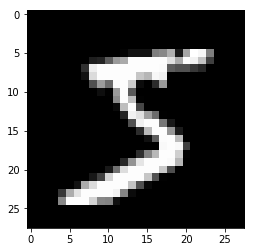

In [17]:
# note that there is a single vector that is reshaped into the square format
plt.imshow(img.view((28,28)));

## Initial Model

We will first try and linear model:

$ A = wx + b $ will be the first model that we will try. We will need the following:

- `w`: weights
- `b`: baseline or bias

In [22]:
weights = torch.randn(784,10)
bias = torch.zeros(10)

### Matrix Multiplication

We will be doing this alot, so its good to get familiar with this. There's a great website called `matrixmultiplication.xyz` that will illustrate how matrix multiplication works. 

<img src="https://snag.gy/HjQrYR.jpg" style="width:600px;"/>
<img src="https://snag.gy/N6cZdL.jpg" style="width:600px;"/>


#### Matrix multiplication function

The following function multiplies two arrays element by element

In [39]:
def matmul(a,b):
    
    # gets the shapes of the input arrays
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    
    # checks to make sure that the
    # inner dimensions are the same
    assert ac==br
    
    # initializes the new array
    c = torch.zeros(ar, bc)
    
    # loops by row in A
    for i in range(ar):
        
        # loops by col in B
        for j in range(bc):
            
            # for each value
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c

#### Let's do a quick sample

Will use the first 5 images from the validation data and multiply them by the weights of the matrix

In [40]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

#### will time the operation

In [41]:
%time t1=matmul(m1, m2)

CPU times: user 605 ms, sys: 2.21 ms, total: 607 ms
Wall time: 606 ms


In [42]:
t1.shape

torch.Size([5, 10])

### How can we do this faster?

We can do this with element-wise operations. We will use pytorch's tensor to illustrate this. When using pytorch objects, Operators (+,-,*,/,>,<,==) are usually element-wise. Examples of element-wise operations:

In [43]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); 
a, b, m

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]), tensor([[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]))

In [44]:
# Addition
print(a + b)

# comparisons
print(a < b)

# can summarize
print((a < b).float().mean())

# frobenius norm
print((m*m).sum().sqrt())

tensor([12., 14.,  3.])
tensor([0, 1, 1], dtype=torch.uint8)
tensor(0.6667)
tensor(16.8819)


#### If we adjust the matmul 

```python
for k in range(ac): # or br
    c[i,j] += a[i,k] * b[k,j]
```

will be replaced by

```python
c[i,j] = (a[i,:] * b[:,j]).sum()
```



In [51]:
def matmul(a,b):
    
    # gets the shapes of the input arrays
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    
    # checks to make sure that the
    # inner dimensions are the same
    assert ac==br
    
    # initializes the new array
    c = torch.zeros(ar, bc)
    
    # loops by row in A
    for i in range(ar):
        
        # loops by col in B
        for j in range(bc):
            
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

After the performance changes, the multiplication is much much faster

In [52]:
%time t1=matmul(m1, m2)

CPU times: user 1.57 ms, sys: 864 µs, total: 2.44 ms
Wall time: 1.57 ms


To test it we will write another function to compare matrices. The reason for this is that due to rounding errors from math operations, matrices may not be exactly the same. As a result, we want a function that will "is a equal to b **within some tolerance**"

In [55]:
#export
def near(a,b): 
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

def test_near(a,b): 
    test(a,b,near)


In [56]:
test_near(t1, matmul(m1, m2))

## Broadcasting

The term broadcasting describes how arrays with different shapes are treated during arithmetic operations. The term broadcasting was first used by Numpy.

From the Numpy Documentation:

```
The term broadcasting describes how numpy treats arrays with 
different shapes during arithmetic operations. Subject to certain 
constraints, the smaller array is “broadcast” across the larger 
array so that they have compatible shapes. Broadcasting provides a 
means of vectorizing array operations so that looping occurs in C
instead of Python. It does this without making needless copies of 
data and usually leads to efficient algorithm implementations.
```

In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

<img src="https://www.tutorialspoint.com/numpy/images/array.jpg" />

#### Example: broadcasting against a constant scalar

In [58]:
a

tensor([10.,  6., -4.])

In [59]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

In [60]:
a + 1


tensor([11.,  7., -3.])

In [61]:
2 * m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

How are we able to do a > 0? 0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

#### Example: broadcasting vector against a matrix

In [62]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [64]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [65]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [66]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [67]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a stride of 0.



In [70]:
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [71]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [73]:
# even though it may appear to be a 3x3, if we 
# look at the memory, its only storing a single copy
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [75]:
# the stride, tells when it is going
# row to row, it takes 0 steps (constant values)
# column to column it takes 1 step
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value `[None]` or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1). This will be important later when using matrix multiplication in modeling



In [78]:
print(c.unsqueeze(0))

tensor([[10., 20., 30.]])


In [79]:
print(c.unsqueeze(1))

tensor([[10.],
        [20.],
        [30.]])


In [80]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [81]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [82]:
c.shape, c[None].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

Note the change from a size 3 to a 1 x 3 or a 3 x 1.

The syntax can also be shortened as follows:
You can always skip trailling `':'s`. And `'...'` means 'all preceding dimensions'


In [85]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [86]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

### Excel can be very helpful

Here is an excel sheet illustrating broadcasting

<img src='https://snag.gy/J1KMew.jpg' style="width:800px" />

### Back to our function

Lets take advantage of broadcasting and reduce the loops in our `matmul` function:

We will replace:

```python
    # loops  by col in B
        for j in range(bc):
            
            c[i,j] = (a[i,:] * b[:,j]).sum()
```

With 

```python
c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
```

#### So what's happening

**`a[i,:]`** looks at a rank 1 tensor

**`.unsqueeze(-1)`** makes it 2d, the `-1` means the last dimension

**`* b`** broadcast over `b`

**`.sum(dim=0)`** sum along the first axis

In [89]:
def matmul(a,b):
    
    # gets the shapes of the input arrays
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    
    # checks to make sure that the
    # inner dimensions are the same
    assert ac==br
    
    # initializes the new array
    c = torch.zeros(ar, bc)
    
    # loops by row in A
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [90]:
%time t1=matmul(m1, m2)

CPU times: user 440 µs, sys: 283 µs, total: 723 µs
Wall time: 421 µs


In [91]:
test_near(t1, matmul(m1, m2))

 ## Broadcasting Rules
 
 Since multi-dimensional broadcasting can be complicated, make sure to follow some of the rules
 
When operating on two arrays/tensors, Numpy/PyTorch compares their shapes **element-wise**. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a 256*256*3 array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

        Image  (3d array): 256 x 256 x 3
        Scale  (1d array):             3
        Result (3d array): 256 x 256 x 3



 
#### Consider the following examples

In [92]:
# add column in front
c[None,:]

tensor([[10., 20., 30.]])

In [93]:
c[None,:].shape

torch.Size([1, 3])

In [94]:
# add column in back
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [95]:
c[:,None].shape

torch.Size([3, 1])

In [96]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

## Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

the subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

```python
c[i,j] += a[i,k] * b[k,j]
c[i,j] = (a[i,:] * b[:,j]).sum()
```

Consider some rearrangement, move the target to the right, and get rid of names

```python
a[i,k] * b[k,j] -> c[i,j]
[i,k] * [k,j] -> [i,j]
ik,kj -> [ij]
```


In [97]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [99]:
%timeit -n 10 _=matmul(m1, m2)

47.7 µs ± 4.04 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Notes on performance

Its unfortunate that there's another language that is very performant hidden in einsum. THere's currently been a lot of interest and development focused on performant langauges. Here's a link to some of the work being done for language called 'halide'

[http://halide-lang.org/](http://halide-lang.org/)


#### pytorch opUnfo
We've sped things up, but the pytorch op is optimized even more. Even with vectorized operations, there's slow and fast ways of handling memory. Unfortunately most programmers don't have access to this, short of using functions provided in `BLAS` libraries (Basic Linear Algebra Subprograms)

Topic to look up: Tensor Comprehensions

In [101]:
%timeit -n 10 t2 = m1.matmul(m2)

14 µs ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Because multiplications occur so often there's shorthand for this operation

In [102]:
t2 = m1@m2

In [105]:
!python notebook2script.py lesson82.ipynb

Converted lesson82.ipynb to nb_lesson82.py
